## Theory

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

h = 0.1
k = h**2
mu = 1
r = h**2/(mu*k)

th = np.linspace(0, 2*np.pi, 100)
b = r*(np.cos(th) - 1)

plt.plot(th, b, label=r"$\beta(\theta)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\beta(\theta)$")
plt.legend()
plt.grid()
plt.show()



In [ ]:
N = 5
S = [(n, m) for n in range(N) for m in range(N)]
print(f"Length of S: {len(S)}")
print("First few elements:", S[:5])


In [ ]:
N = 5


def build_2d_fdm_matrix(Nx, Ny, alpha, beta, x_min, x_max, y_min, y_max):
    """
    Build the (Nx*Ny) x (Nx*Ny) coefficient matrix for the
    2D finite-difference discretization of

        f_{n-1,m} + f_{n,m-1} + f_{n+1,m} + f_{n,m+1}
         - g_{n,m} * f_{n,m} = 0,

    where

        g_{n,m} = 4 + h^2( -2/alpha - 2/beta
                           + 4*x_n^2 / alpha^2
                           + 4*y_m^2 / beta^2 ).

    Dirichlet boundary nodes (if n=0, n=Nx-1, m=0, or m=Ny-1)
    are enforced by setting row = identity row
    => f_{boundary} = 0.

    Returns:
        A, where A is a list-of-lists for the (Nx*Ny) system.
    """

    # Grid spacing (assuming uniform grid in x and y):
    hx = (x_max - x_min) / (Nx - 1)
    hy = (y_max - y_min) / (Ny - 1)

    # We will store the matrix in a 2D Python list:
    N = Nx * Ny  # total number of unknowns
    A = [[0.0 for _ in range(N)] for _ in range(N)]

    # Helper to turn (n,m) into a single index:
    def idx(n, m):
        return n + Nx * m

    # Build matrix row-by-row:
    for m in range(Ny):
        # Compute physical y-coordinate at row m:
        y_m = y_min + m * hy
        for n in range(Nx):
            # Compute physical x-coordinate at column n:
            x_n = x_min + n * hx

            row = idx(n, m)

            # Check if (n,m) is on the boundary:
            if n == 0 or n == Nx - 1 or m == 0 or m == Ny - 1:
                # Enforce Dirichlet f_{n,m}=0 by putting a 1 on the diagonal
                # and 0 elsewhere in this row:
                A[row][row] = 1.0
                continue

            # Compute g_{n,m} for the interior:
            g_nm = 4.0 + (hx**2) * (
                -2.0 / alpha
                - 2.0 / beta
                + 4.0 * (x_n**2) / (alpha**2)
                + 4.0 * (y_m**2) / (beta**2)
            )

            # Fill the five-point stencil:
            #   f_{n-1,m}, f_{n+1,m}, f_{n,m-1}, f_{n,m+1}, and diagonal

            # left neighbor (n-1,m)
            A[row][idx(n - 1, m)] = 1.0
            # right neighbor (n+1,m)
            A[row][idx(n + 1, m)] = 1.0
            # down neighbor (n,m-1)
            A[row][idx(n, m - 1)] = 1.0
            # up neighbor (n,m+1)
            A[row][idx(n, m + 1)] = 1.0

            # diagonal:
            A[row][row] = -g_nm

    return A


# ----------------------------------------------
# Example usage:
if __name__ == "__main__":
    Nx, Ny = 5, 5
    alpha, beta = 1.0, 1.5
    x_min, x_max = -1.0, 1.0
    y_min, y_max = -1.0, 1.0

    # Build the coefficient matrix
    A = build_2d_fdm_matrix(Nx, Ny, alpha, beta, x_min, x_max, y_min, y_max)

    # Print out A row by row (small grids only!)
    for row_index, row_data in enumerate(A):
        print(f"Row {row_index}:", row_data)

In [ ]:
def build_1D_matrix(Nx, Ny, alpha, x_min, x_max, y_min, y_max):
    """
    Build the (Nx*Ny) x (Nx*Ny) coefficient matrix for the
    2D finite-difference discretization of

        f_{n-1,m} + f_{n,m-1} + f_{n+1,m} + f_{n,m+1}
         - g_{n,m} * f_{n,m} = 0,

    where

        g_{n,m} = 4 + hx^2( -2/alpha - 2/beta
                           + 4*x_n^2 / alpha^2
                           + 4*y_m^2 / beta^2 ).

    Dirichlet boundary nodes (if n=0, n=Nx-1, m=0, or m=Ny-1)
    are enforced by setting the row to an identity row
    => f_boundary = 0.

    Returns:
       A, where A is a list-of-lists representing the system.
    """
    # Grid spacing (assuming uniform grid in x and y):
    hx = (x_max - x_min) / (Nx - 1)
    hy = (y_max - y_min) / (Ny - 1)
    total_nodes = Nx * Ny
    # Use a contiguous 1D list for efficient memory usage
    A = [0.0] * (total_nodes * total_nodes)

    # Helper: convert (n, m) grid coordinates to a single index
    def grid_index(n, m):
        return n + Nx * m

    # Helper: compute index in the raveled vector for row i and column j
    def mat_index(i, j):
        return i * total_nodes + j

    # Build the matrix by iterating over grid points:
    for m in range(Ny):
        y_m = y_min + m * hy
        for n in range(Nx):
            i = grid_index(n, m)
            # Enforce Dirichlet boundary conditions:
            if n == 0 or n == Nx - 1 or m == 0 or m == Ny - 1:
                A[mat_index(i, i)] = 1.0
                continue

            x_n = x_min + n * hx
            g_nm = 4.0 + (hx**2) * (
                -2.0 / alpha
                -2.0 / beta
                + 4.0 * x_n**2 / (alpha**2)
                + 4.0 * y_m**2 / (beta**2)
            )

            # Five-point stencil entries:
            A[mat_index(i, grid_index(n - 1, m))] = 1.0   # left neighbor
            A[mat_index(i, grid_index(n + 1, m))] = 1.0   # right neighbor
            A[mat_index(i, grid_index(n, m - 1))] = 1.0   # down neighbor
            A[mat_index(i, grid_index(n, m + 1))] = 1.0   # up neighbor

            # Diagonal term:
            A[mat_index(i, i)] = -g_nm
            
    return A

def unravel(A, Nx, Ny):
    """
    Unravel a 1D list into a 2D list for easier access.
    """
    return [A[i * (Nx * Ny):(i + 1) * (Nx * Ny)] for i in range(Nx * Ny)]


# Example usage:
Nx, Ny = 5, 5
alpha, beta = 1.0, 1.5
x_min, x_max = -1.0, 1.0
y_min, y_max = -1.0, 1.0

# Build the coefficient matrix
F = build_1D_matrix(Nx, Ny, alpha, x_min, x_max, y_min, y_max)

S = unravel(F, Nx, Ny)


In [ ]:
M = 10
h = 1/5
beta = 1.5
mu_s = 0.3
mu_i = 0.50

In [ ]:
S = np.zeros((M, M))
I = np.zeros((M, M))

N = 4

I[N:-N, N:-N] = 1

for i in range(1, M-1):
    for j in range(1, M-1):
        S[i, i] += h * (1 - beta * I[i, i] - 4 * mu_s / (h**2))
        S[i+1, j] += mu_s / h
        S[i-1, j] += mu_s / h
        S[i, j+1] += mu_s / h
        S[i, j-1] += mu_s / h
        

print(S)
# Boundary conditions
S[0, :] = 0
S[-1, :] = 0
S[:, 0] = 0
S[:, -1] = 0





---

## SIR Model


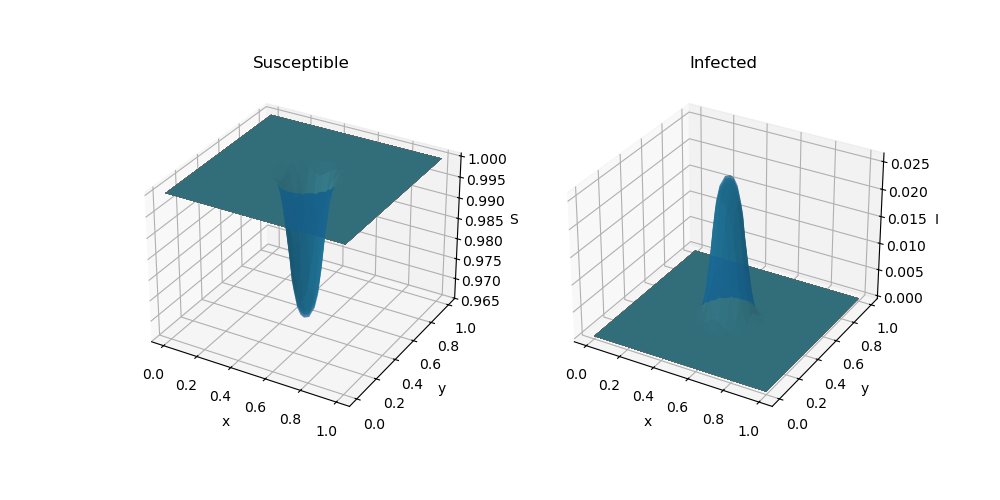

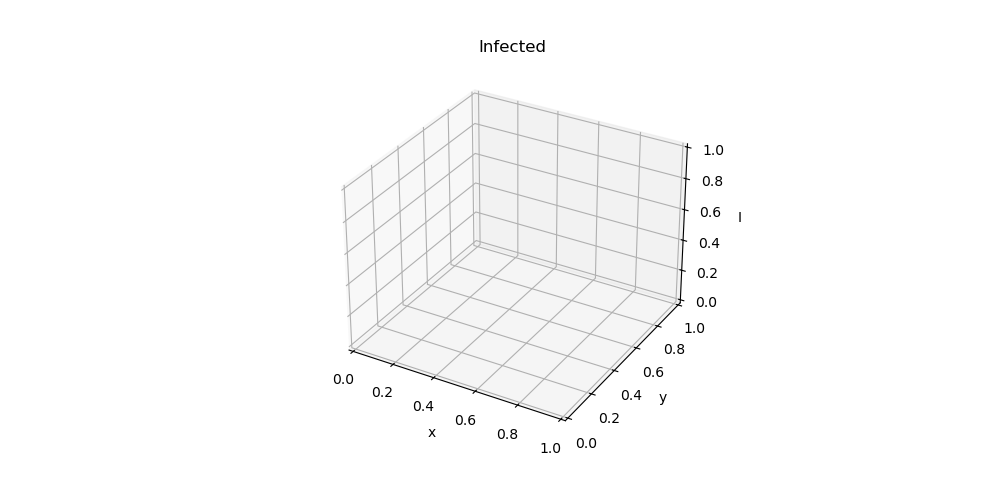

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x34fdcd790>>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/matte/lib/python3.13/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/matte/lib/python3.13/site-packages/matplotlib/backend_bases.py", line 1152, in _on_timer
    ret = func(*args, **kwargs)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/matte/lib/python3.13/site-packages/matplotlib/animation.py", line 1454, in _step
    self._init_draw()
    ~~~~~~~~~~~~~~~^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/matte/lib/python3.13/site-packages/matplotlib/animation.py", line 1770, in _init_draw
    self._draw_frame(frame_data)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/matte/lib/python3.13/site-packages/matplotlib/anim